# I. VGG model

## 1. Introduction

VGG is a deep convolutional neural network that was proposed by Karen Simonyan and Andrew Zisserman [1]. VGG is an acronym for their group name, [Visual Geometry Group](https://www.robots.ox.ac.uk/~vgg/), from the Oxford University. This model secured 2nd place in the ILSVRC-2014 competition where 92.7% classification performance was achieved. The VGG model investigates the depth of layers with a very small convolutional filter size (3 × 3) to deal with large-scale images. The authors released a series of VGG models with different layer lengths, from 11 to 19, which is presented in the following table.

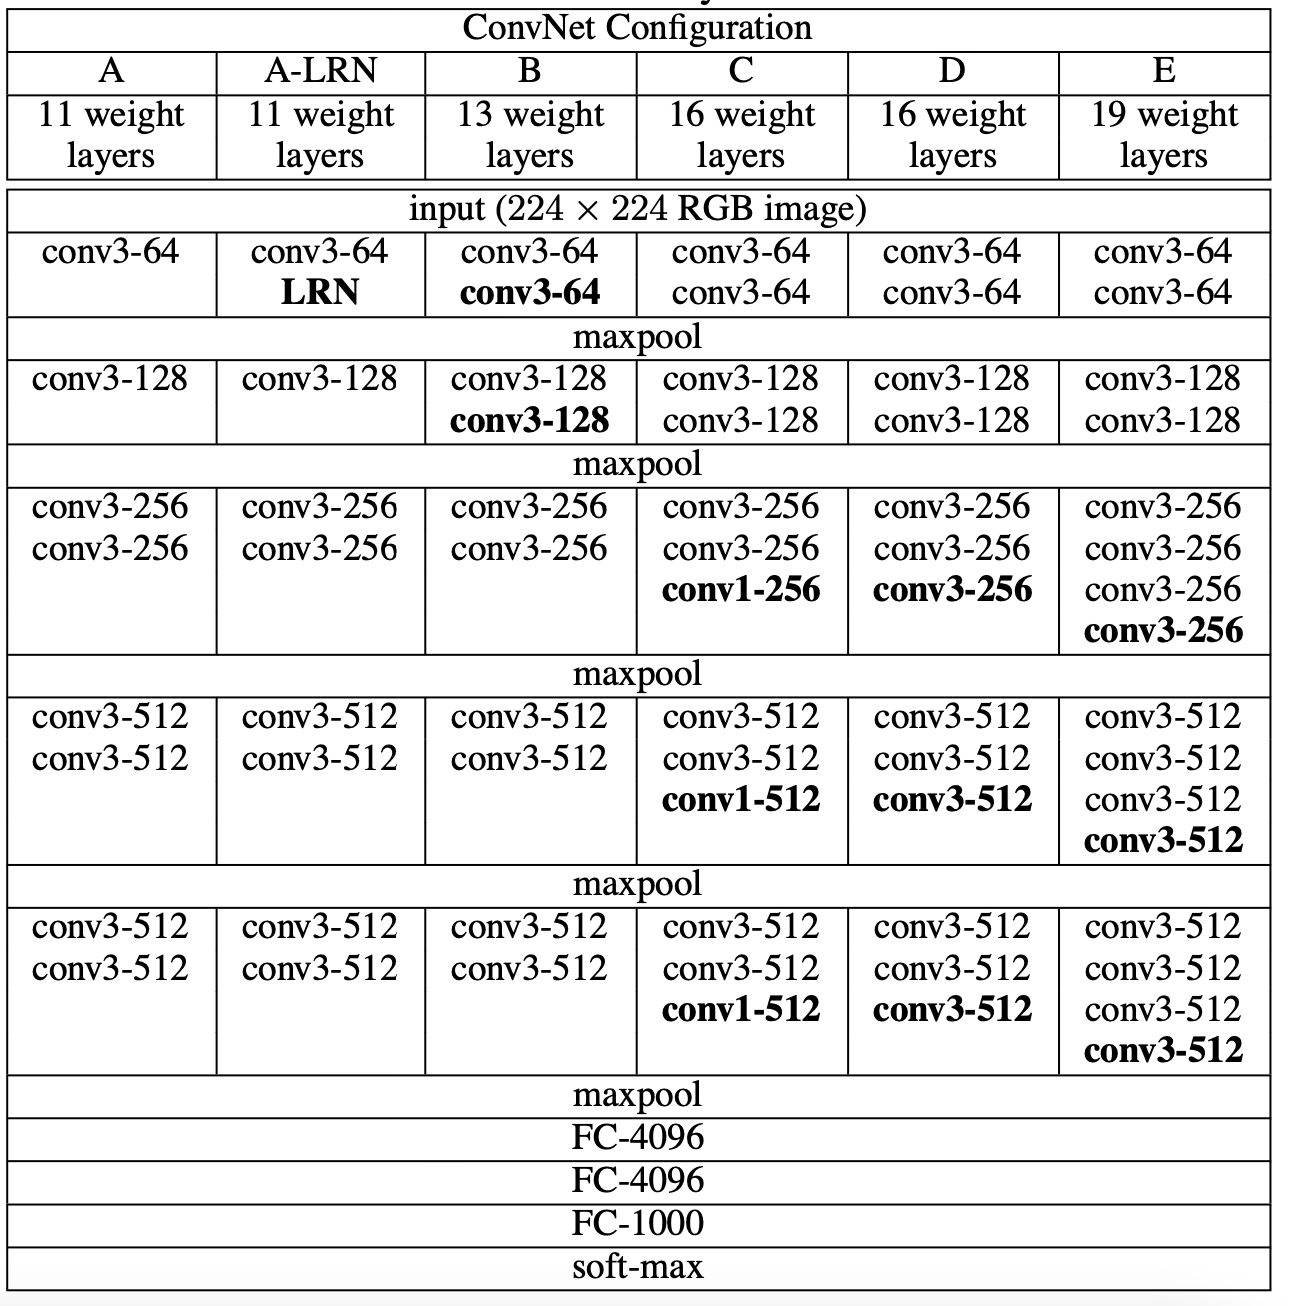

In summary:
- All configurations of VGG have block structures.
- Each VGG block consists of a sequence of convolutional layers which are followed by a max-pooling layer. The same kernel size (3 × 3) is applied over all convolutional layers. Besides, the authors used a padding size of 1 to keep the size of the output after each convolutional layer. A max-pooling of size 2 × 2 with strides of 2 is also applied to halve the resolution after each block
- Each VGG model has two fully connected hidden layers and one fully connected output layer.

In this post, we only focus on the deployment of the VGG16, its architecture as well as its implementation on Keras. Other configurations are constructed similarly.

The structure of VGG16 is described by the following figure:

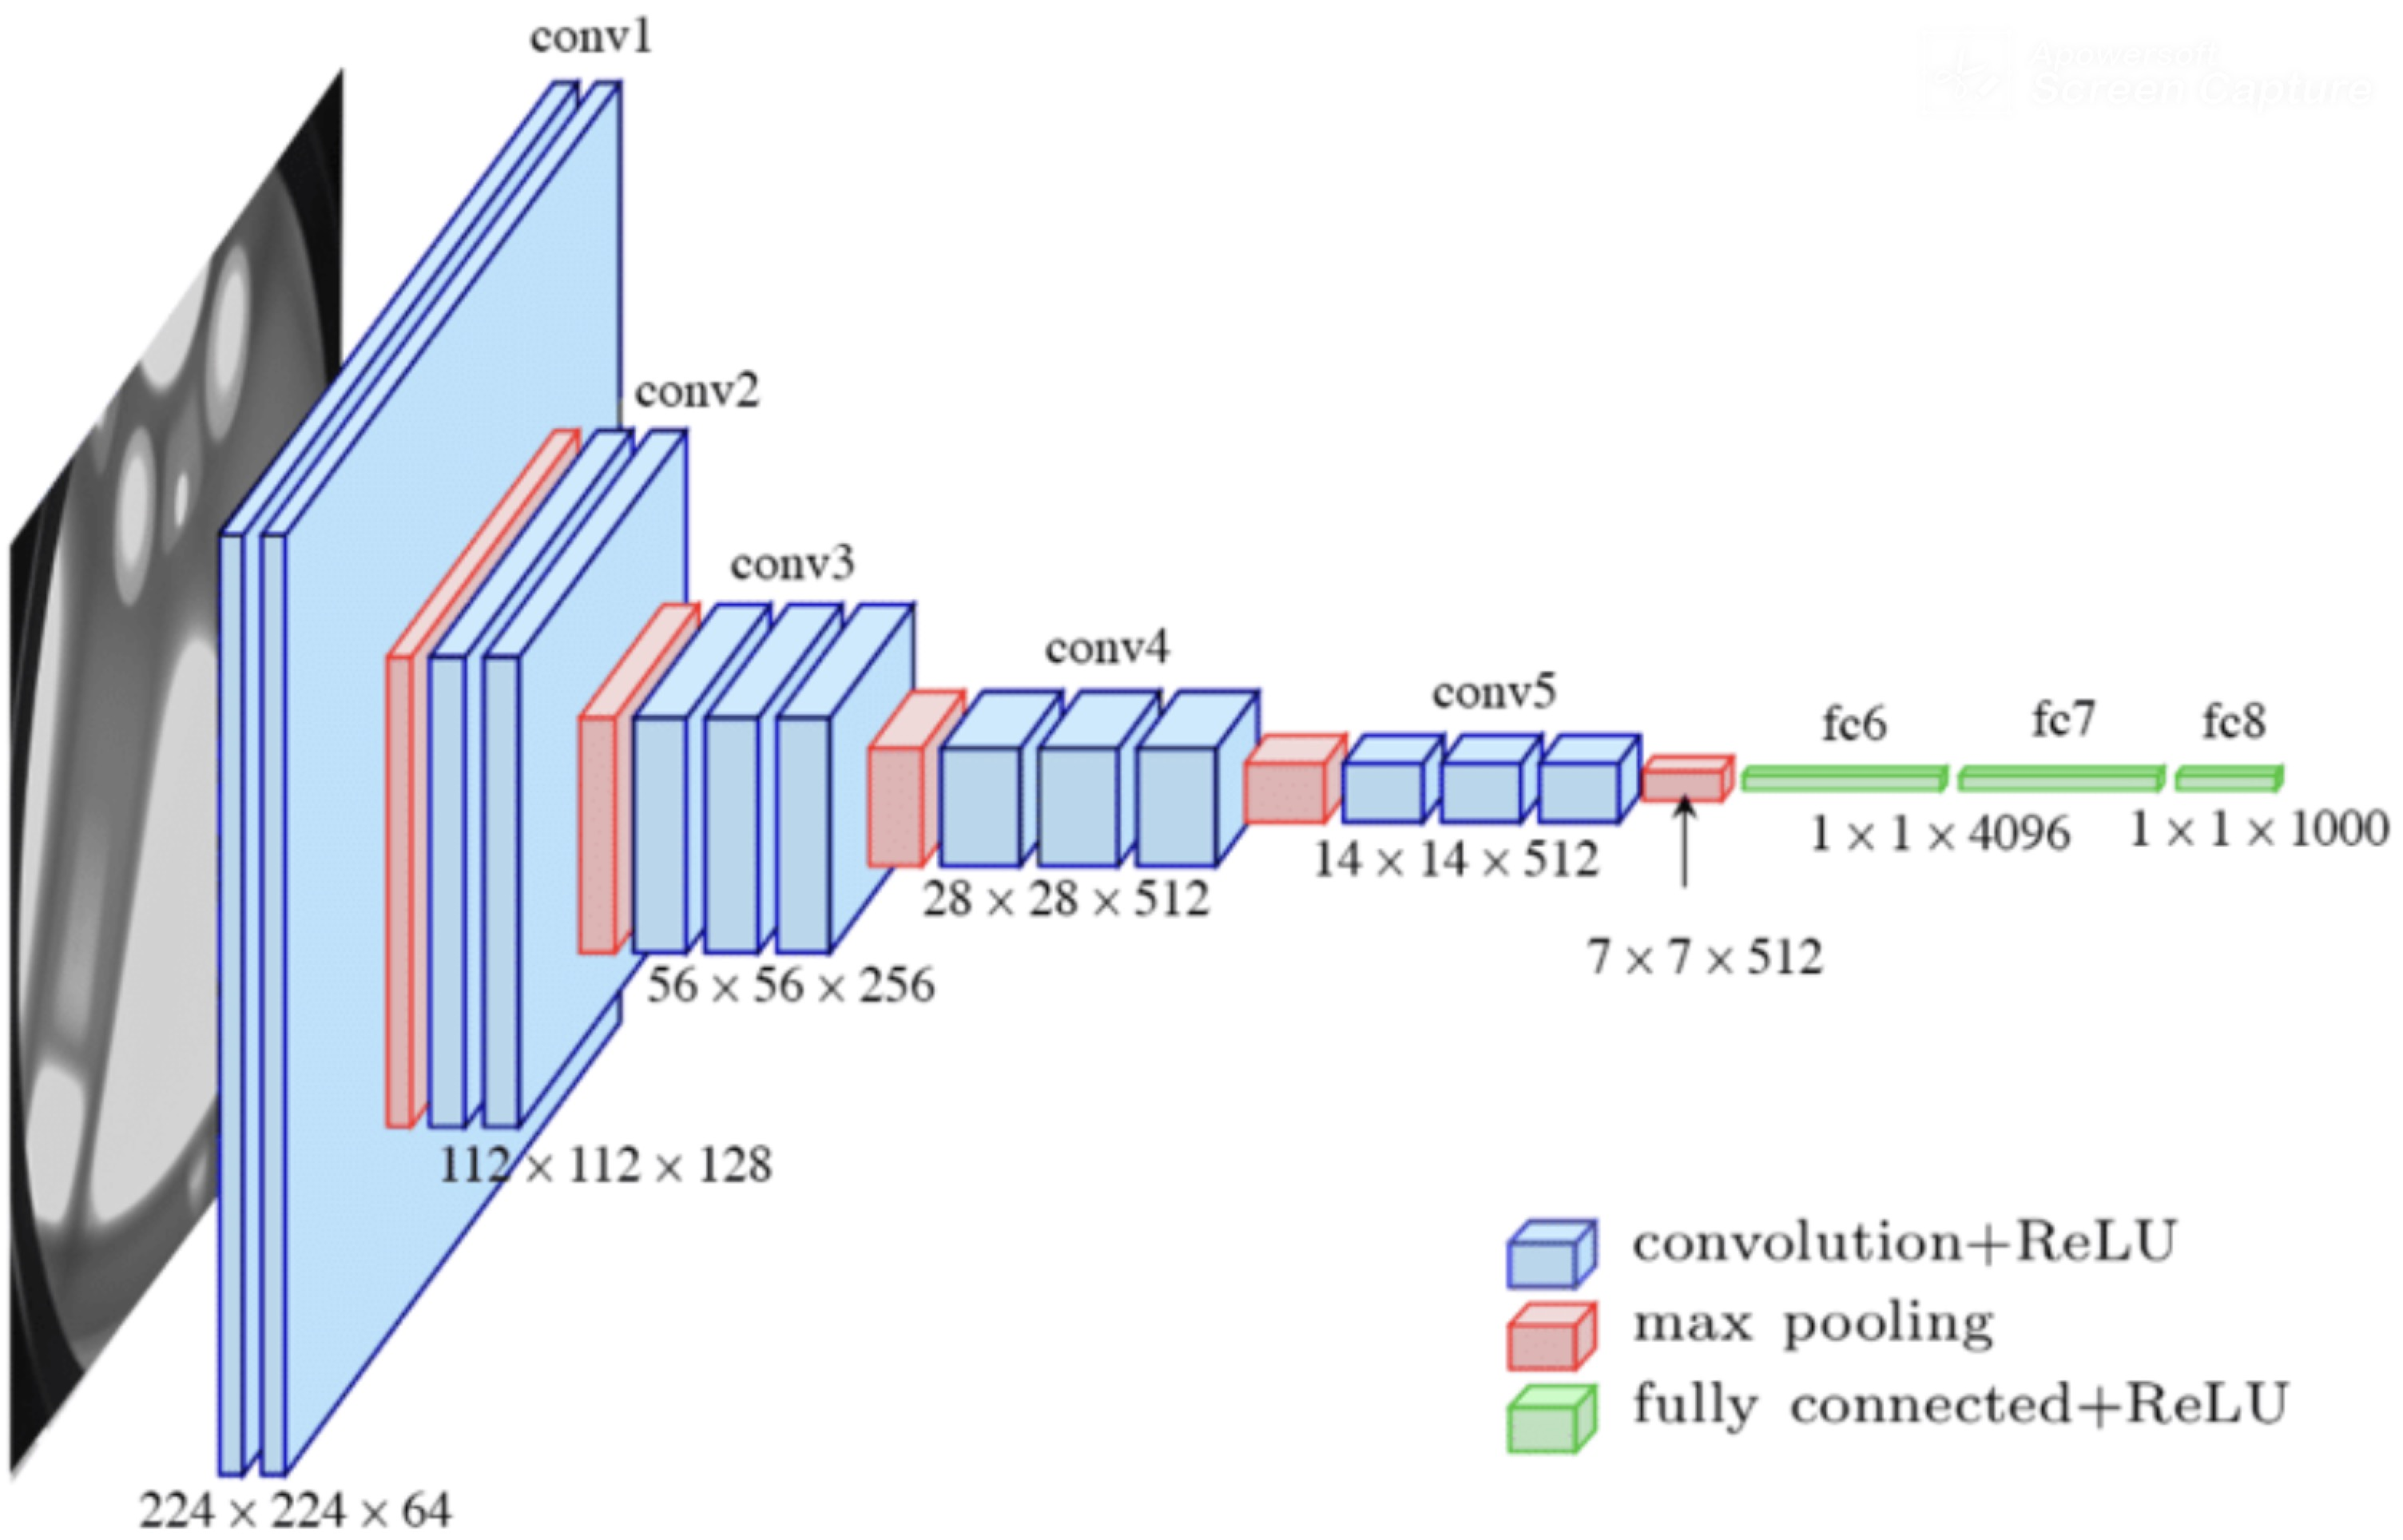

VGG16 is composed of 13 convolutional layers, 5 max-pooling layers, and 3 fully connected layers. Therefore, the number of layers having tunable parameters is 16 (13 convolutional layers and 3 fully connected layers). That is the reason why the model name is VGG16. The number of filters in the first block is 64, then this number is doubled in the later blocks until it reaches 512. This model is finished by two fully connected hidden layers and one output layer. The two fully connected layers have the same neuron numbers which are 4096. The output layer consists of 1000 neurons corresponding to the number of categories of the Imagenet dataset. In the next section, we are going to implement this architecture on Keras.

## 2. Implementation of VGG16 on Keras
Firstly, we need to import some necessary libraries:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# import metric
from tensorflow.keras.metrics import categorical_crossentropy
# optimization method 
from tensorflow.keras.optimizers import SGD

import numpy as np
import pandas as pd 

Once all necessary libraries are ready, the model can be implemented by the following function:

In [ ]:
def VGG16():
  # Initialize the model
  model = Sequential(name="VGG16")

  # layer 1-2: 2 convolutional layers + 1 max-pooling layer 
  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', 
                   input_shape = (224,224,3)))
  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

  # number of filters and convolutions in each layer:
  filters_convs = [(128, 2), (256, 3), (512, 3), (512,3)]
  
  for n_filters, n_convs in filters_convs:
    for _ in np.arange(n_convs):
      model.add(Conv2D(filters = n_filters, kernel_size = (3,3), padding = 'same', activation = 'relu'))
    # max-pooling layer 
    model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1000,activation = 'softmax'))

  # compile the model with a loss function, a metric and an optimization method
  opt = SGD(learning_rate = 0.005) # stochastic gradient descent method with learning rate lr = 0.1
  model.compile(loss = categorical_crossentropy, 
                optimizer = opt, 
                metrics = ['accuracy'])
  return model

Now, let’s see the detailed information in each layer of the model:

In [ ]:
vgg16_model = VGG16()
vgg16_model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                        

As the number of filters increases following the model depth, hence the number of parameters increases significantly in the later layers. Especially, the parameter number in the two fully connected hidden layers is very large, with 102, 764, 544, and 16, 781, 312 parameters, respectively. It accounts for 86.4% parameters of the whole model.

A large number of parameters may reduce the model performance. Sometimes, it leads to overfitting. A natural question arises: Is it possible to replace the fully connected layers with something to reduce the model complexity? The NiN model, which we are going to discuss in the next section, is an appropriate answer to this question.

**References:**

[1] Simonyan, Karen, and Andrew Zisserman. “Very deep convolutional networks for large-scale image recognition.” arXiv preprint arXiv:1409.1556 (2014).